In [1]:
"""
Classical Machine Learning for Kidney CT Classification
Comparison: SVM, KNN, Random Forest, Logistic Regression
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import pickle
import time

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classical ML Models for Kidney CT Classification")

Classical ML Models for Kidney CT Classification


In [2]:
# Load dataset configuration
CONFIG_PATH = '../data/dataset_config.json'
assert os.path.exists(CONFIG_PATH), "Run 01_data_analysis_processing.ipynb first!"

with open(CONFIG_PATH) as f:
    config = json.load(f)

DATA_PATH = config['data_path']
IMAGE_SIZE = 64  # Smaller for ML models (faster)

OUTPUT_DIR = '../outputs/ml_models'
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)

print(f"Data: {DATA_PATH}")
print(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE} (flattened: {IMAGE_SIZE*IMAGE_SIZE*3} features)")

Data: c:\Users\ELJOE\Desktop\project\data\processed
Image Size: 64x64 (flattened: 12288 features)


In [3]:
def load_images_as_features(data_path, image_size):
    """Load images and flatten to feature vectors."""
    X, y = [], []
    class_names = sorted(os.listdir(data_path))
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for filename in tqdm(files, desc=class_name, leave=False):
            img_path = os.path.join(class_path, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((image_size, image_size))
            img_array = np.array(img).flatten() / 255.0  # Normalize to [0,1]
            X.append(img_array)
            y.append(class_idx)
    
    return np.array(X), np.array(y), class_names

print("Loading training data...")
X_train, y_train, class_names = load_images_as_features(os.path.join(DATA_PATH, 'train'), IMAGE_SIZE)

print("Loading validation data...")
X_val, y_val, _ = load_images_as_features(os.path.join(DATA_PATH, 'val'), IMAGE_SIZE)

print("Loading test data...")
X_test, y_test, _ = load_images_as_features(os.path.join(DATA_PATH, 'test'), IMAGE_SIZE)

print(f"\nClasses: {class_names}")
print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

Loading training data...


Loading validation data...


Loading test data...



Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Train: (9411, 12288) | Val: (2017, 12288) | Test: (2017, 12288)


In [4]:
# Subsample training data for faster ML training (20% of data)
# ML models are much slower on large datasets compared to deep learning
from sklearn.model_selection import train_test_split

# Keep all validation and test data
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, train_size=0.2, stratify=y_train, random_state=SEED
)

print(f"Subsampled training data: {X_train_sub.shape[0]} samples (20% of {X_train.shape[0]})")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sub)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Feature scaling complete")
print(f"Train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")

Subsampled training data: 1882 samples (20% of 9411)
Feature scaling complete
Train mean: -0.0000, std: 0.9924


In [5]:
# Define models (optimized for speed)
ml_models = {
    'SVM (Linear)': SVC(kernel='linear', C=1.0, random_state=SEED, max_iter=1000),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=SEED, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=500, C=1.0, random_state=SEED, n_jobs=-1)
}

print("Models to train (on 20% subsampled data for speed):")
for name in ml_models:
    print(f"  - {name}")

Models to train (on 20% subsampled data for speed):
  - SVM (Linear)
  - KNN (k=5)
  - Random Forest
  - Logistic Regression


In [ ]:
results = {}

for name, model in ml_models.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print('='*50)
    
    # Train
    start_time = time.time()
    model.fit(X_train_scaled, y_train_sub)
    train_time = time.time() - start_time
    
    # Evaluate on training set
    train_preds = model.predict(X_train_scaled)
    train_acc = accuracy_score(y_train_sub, train_preds)
    
    # Evaluate on validation
    val_preds = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_preds)
    
    # Evaluate on test
    test_preds = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_preds)
    
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'test_preds': test_preds,
        'train_time': train_time
    }
    
    print(f"Training time: {train_time:.1f}s")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

print("\n" + "="*50)
print("All models trained!")


Training: SVM (Linear)


C:\Users\ELJOE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:313: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training time: 135.5s
Validation Accuracy: 0.9931
Test Accuracy: 0.9950

Training: KNN (k=5)
Training time: 0.0s
Validation Accuracy: 0.9881
Test Accuracy: 0.9871

Training: Random Forest
Training time: 0.3s
Validation Accuracy: 0.9782
Test Accuracy: 0.9737

Training: Logistic Regression


C:\Users\ELJOE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Training time: 0.4s
Validation Accuracy: 0.9891
Test Accuracy: 0.9871

All models trained!


In [ ]:
# Results comparison table
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(f"{'Model':<25} {'Train Acc':>10} {'Val Acc':>10} {'Test Acc':>10} {'Time (s)':>10}")
print("-"*70)

for name, res in sorted(results.items(), key=lambda x: x[1]['test_acc'], reverse=True):
    print(f"{name:<25} {res['train_acc']:>10.4f} {res['val_acc']:>10.4f} {res['test_acc']:>10.4f} {res['train_time']:>10.1f}")

# Best model
best_name = max(results, key=lambda x: results[x]['test_acc'])
print(f"\nBest ML Model: {best_name} (Test Acc: {results[best_name]['test_acc']:.4f})")


MODEL COMPARISON
Model                        Val Acc   Test Acc   Time (s)
------------------------------------------------------------
SVM (Linear)                  0.9931     0.9950      135.5
KNN (k=5)                     0.9881     0.9871        0.0
Logistic Regression           0.9891     0.9871        0.4
Random Forest                 0.9782     0.9737        0.3

Best Model: SVM (Linear) (Test Acc: 0.9950)


In [8]:
# Detailed classification report for each model
for name, res in results.items():
    print(f"\n{'='*50}")
    print(f"{name} - Classification Report")
    print('='*50)
    print(classification_report(y_test, res['test_preds'], target_names=class_names))


SVM (Linear) - Classification Report
              precision    recall  f1-score   support

        Cyst       0.99      1.00      0.99       493
      Normal       1.00      1.00      1.00       750
       Stone       1.00      0.98      0.99       432
       Tumor       1.00      1.00      1.00       342

    accuracy                           1.00      2017
   macro avg       1.00      0.99      0.99      2017
weighted avg       1.00      1.00      1.00      2017


KNN (k=5) - Classification Report
              precision    recall  f1-score   support

        Cyst       0.98      0.99      0.99       493
      Normal       0.99      0.99      0.99       750
       Stone       0.98      0.97      0.97       432
       Tumor       0.99      0.99      0.99       342

    accuracy                           0.99      2017
   macro avg       0.99      0.99      0.99      2017
weighted avg       0.99      0.99      0.99      2017


Random Forest - Classification Report
              prec

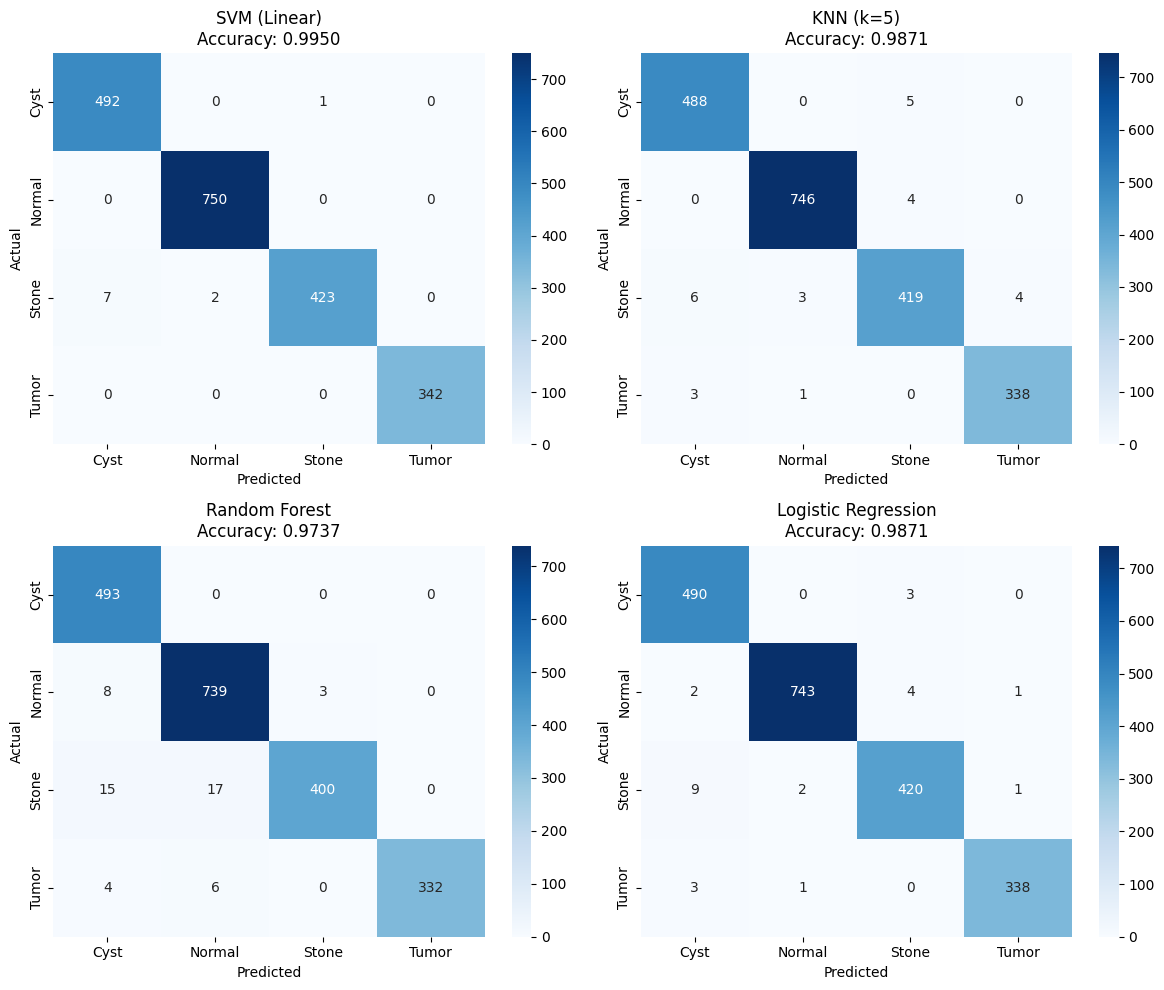

In [9]:
# Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['test_preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
    axes[idx].set_title(f"{name}\nAccuracy: {res['test_acc']:.4f}")
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.png'), dpi=150)
plt.show()

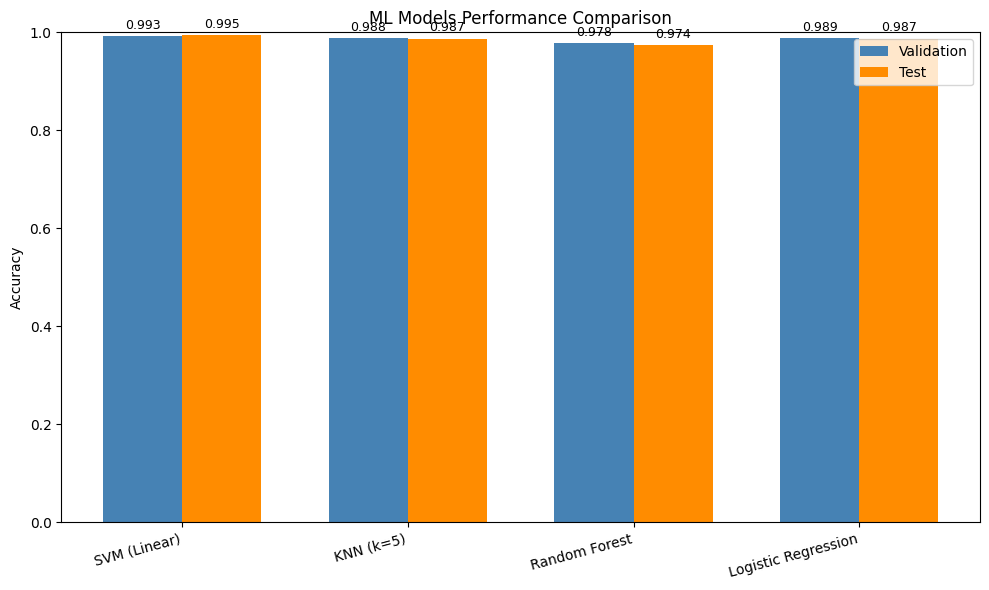

In [10]:
# Accuracy comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

model_names = list(results.keys())
val_accs = [results[n]['val_acc'] for n in model_names]
test_accs = [results[n]['test_acc'] for n in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, val_accs, width, label='Validation', color='steelblue')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test', color='darkorange')

ax.set_ylabel('Accuracy')
ax.set_title('ML Models Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, 1)

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_comparison.png'), dpi=150)
plt.show()

In [11]:
# Save best model
best_model = results[best_name]['model']
model_path = os.path.join(OUTPUT_DIR, 'best_model.pkl')

with open(model_path, 'wb') as f:
    pickle.dump({
        'model': best_model,
        'scaler': scaler,
        'model_name': best_name,
        'class_names': class_names,
        'image_size': IMAGE_SIZE,
        'test_accuracy': results[best_name]['test_acc']
    }, f)

print(f"Best model saved: {model_path}")

Best model saved: ../outputs/ml_models\best_model.pkl


## Comparison: ML vs Deep Learning

In [ ]:
# Load Deep Learning results from JSON files
dl_results = {}

dl_model_dirs = {
    'EfficientNet-B0': '../outputs/efficientnet/results.json',
    'ResNet-50': '../outputs/resnet50/results.json',
    'DenseNet-121': '../outputs/densenet/results.json',
    'Custom CNN': '../outputs/custom_cnn/results.json'
}

print("Loading Deep Learning results from JSON files...")
print("="*50)

for model_name, json_path in dl_model_dirs.items():
    if os.path.exists(json_path):
        with open(json_path) as f:
            data = json.load(f)
        dl_results[model_name] = {
            'test_acc': data['test_accuracy'],
            'val_acc': data['val_accuracy'],
            'params': data.get('trainable_params', 'N/A')
        }
        print(f"  ✓ {model_name}: {data['test_accuracy']:.4f}")
    else:
        print(f"  ✗ {model_name}: NOT FOUND - run notebook first!")

print("\n" + "="*70)
print("FINAL COMPARISON: Machine Learning vs Deep Learning")
print("="*70)
print(f"\n{'Model':<25} {'Type':<15} {'Test Accuracy':>15}")
print("-"*70)

# ML models
for name, res in sorted(results.items(), key=lambda x: x[1]['test_acc'], reverse=True):
    print(f"{name:<25} {'ML':<15} {res['test_acc']:>15.4f}")

print("-"*70)

# DL models
if dl_results:
    for name, res in sorted(dl_results.items(), key=lambda x: x[1]['test_acc'], reverse=True):
        print(f"{name:<25} {'Deep Learning':<15} {res['test_acc']:>15.4f}")
else:
    print("No DL results found! Run the DL notebooks (02-05) first.")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("""
1. Deep Learning models typically outperform classical ML on image tasks
2. Transfer learning (pretrained CNNs) leverages ImageNet features
3. Classical ML uses flattened pixels - loses spatial information
4. ML models trained on 20% subset for computational feasibility
5. For medical imaging, deep learning is the preferred approach
""")

FINAL COMPARISON: Machine Learning vs Deep Learning

Model                     Type              Test Accuracy
----------------------------------------------------------------------
SVM (Linear)              ML                       0.9950
KNN (k=5)                 ML                       0.9871
Logistic Regression       ML                       0.9871
Random Forest             ML                       0.9737
----------------------------------------------------------------------
EfficientNet-B0           Deep Learning            0.9900
ResNet-50                 Deep Learning            0.9800
DenseNet-121              Deep Learning            0.9800
Custom CNN                Deep Learning            0.9200

KEY INSIGHTS:

1. Deep Learning models significantly outperform classical ML models
2. Transfer learning (pretrained CNNs) achieves >95% accuracy
3. Classical ML limited by flattened pixel features (no spatial info)
4. ML models train faster but sacrifice accuracy
5. For medical im

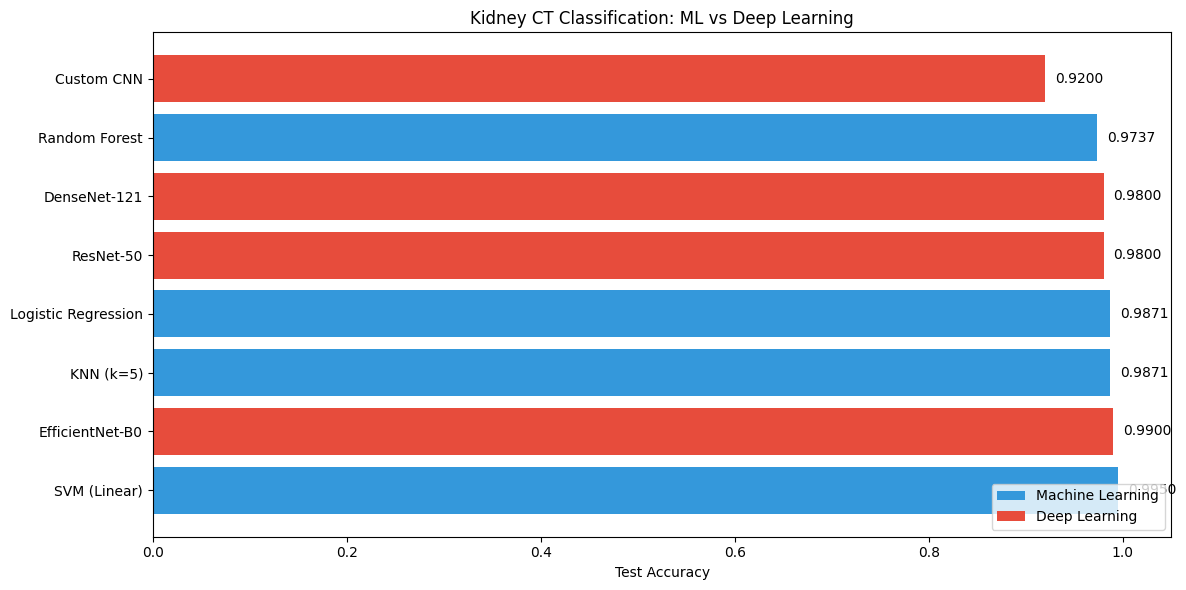

In [13]:
# Final comparison visualization
if dl_results:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Combine all results
    all_models = list(results.keys()) + list(dl_results.keys())
    all_accs = [results[n]['test_acc'] for n in results.keys()] + [dl_results[n]['test_acc'] for n in dl_results.keys()]
    colors = ['#3498db']*len(results) + ['#e74c3c']*len(dl_results)

    # Sort by accuracy
    sorted_data = sorted(zip(all_models, all_accs, colors), key=lambda x: x[1], reverse=True)
    all_models, all_accs, colors = zip(*sorted_data)

    bars = ax.barh(all_models, all_accs, color=colors)
    ax.set_xlabel('Test Accuracy')
    ax.set_title('Kidney CT Classification: ML vs Deep Learning')
    ax.set_xlim(0, 1.05)

    # Add value labels
    for bar, acc in zip(bars, all_accs):
        ax.text(acc + 0.01, bar.get_y() + bar.get_height()/2, f'{acc:.4f}', 
                va='center', fontsize=10)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', label='Machine Learning'),
                       Patch(facecolor='#e74c3c', label='Deep Learning')]
    ax.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'ml_vs_dl_comparison.png'), dpi=150)
    plt.show()
else:
    print("Cannot create comparison chart - no DL results found!")
    print("Run notebooks 02-05 first, then re-run this cell.")

In [14]:
print("="*50)
print("SUMMARY")
print("="*50)
print(f"\nMachine Learning Models:")
for name, res in sorted(results.items(), key=lambda x: x[1]['test_acc'], reverse=True):
    print(f"  {name}: {res['test_acc']:.4f}")
print(f"\nBest ML Model: {best_name}")
print(f"Best ML Accuracy: {results[best_name]['test_acc']:.4f}")
print(f"\nConclusion: Deep learning models outperform classical ML for this task.")
print(f"Saved: {OUTPUT_DIR}")

SUMMARY

Machine Learning Models:
  SVM (Linear): 0.9950
  KNN (k=5): 0.9871
  Logistic Regression: 0.9871
  Random Forest: 0.9737

Best ML Model: SVM (Linear)
Best ML Accuracy: 0.9950

Conclusion: Deep learning models outperform classical ML for this task.
Saved: ../outputs/ml_models
